In [38]:
%matplotlib inline

import numpy as np
import h5py
import torch
import torch.nn.functional as F
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

In [39]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [40]:
# Dataset class definition
class HeatmapTauData(Dataset):
    def __init__(self, hdf5):
        self.file = h5py.File(hdf5, 'r')
        self.ksz_maps = self.file["ksz_maps"]
        self.tau_values = self.file["tau_values"]
        self.num_samples = self.ksz_maps.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        heatmap = torch.tensor(self.ksz_maps[index], dtype=torch.float32)
        tauval = torch.tensor(self.tau_values[index], dtype=torch.float32)
        return heatmap, tauval

In [41]:
# Model definition
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.convo1 = torch.nn.Conv2d(1, 16, 3, 1, 1)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.convo2 = torch.nn.Conv2d(16, 32, 3, 1, 1)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        self.linear1 = torch.nn.Linear(32 * 256 * 256, 128)  # for 1024x1024 input
        self.linear2 = torch.nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.convo1(x)))
        x = self.pool2(F.relu(self.convo2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [42]:
# Load dataset
dataset = HeatmapTauData("all_snapshots.hdf5")
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
val_loader = DataLoader(val_set, batch_size=10)
test_loader = DataLoader(test_set, batch_size=10)

In [43]:
# Normalization values (ensure same device)
tau_min = torch.tensor(dataset.tau_values[:].min(), dtype=torch.float32, device=device)
tau_max = torch.tensor(dataset.tau_values[:].max(), dtype=torch.float32, device=device)

In [51]:
# Model, loss, optimizer
model = Model().to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Reduced LR
blur = T.GaussianBlur(kernel_size=5, sigma=(1.0, 2.0))

train_losses = []
val_losses = []

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for heatmaps, tauvals in train_loader:
        heatmaps = heatmaps.unsqueeze(1).to(device)
        tauvals = tauvals.to(device)

        heatmaps = blur(heatmaps)
        std = heatmaps.std(dim=(2, 3), keepdim=True)
        std = torch.clamp(std, min=1e-4)
        heatmaps = (heatmaps - heatmaps.mean(dim=(2, 3), keepdim=True)) / std

        tauvals = tauvals.view(-1, 1)
        tauvals_norm = (tauvals - tau_min) / (tau_max - tau_min)

        optimizer.zero_grad()
        output = model(heatmaps)
        loss = loss_fn(output, tauvals_norm)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    predictions = []
    targets = []

    with torch.no_grad():
        for val_heatmaps, val_tauvals in val_loader:
            val_heatmaps = val_heatmaps.unsqueeze(1).to(device)
            val_tauvals = val_tauvals.to(device)

            val_heatmaps = blur(val_heatmaps)
            std = val_heatmaps.std(dim=(2, 3), keepdim=True)
            std = torch.clamp(std, min=1e-4)
            val_heatmaps = (val_heatmaps - val_heatmaps.mean(dim=(2, 3), keepdim=True)) / std

            val_tauvals = val_tauvals.view(-1, 1)
            val_tauvals_norm = (val_tauvals - tau_min) / (tau_max - tau_min)

            val_output = model(val_heatmaps)
            val_loss += loss_fn(val_output, val_tauvals_norm).item()

            predictions.append(val_output.cpu())
            targets.append(val_tauvals_norm.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    preds = torch.cat(predictions).squeeze().numpy()
    targets_np = torch.cat(targets).squeeze().numpy()
    r2 = r2_score(targets_np, preds)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, R^2: {r2:.4f}")

    # Debug: print sample predictions
    if epoch == 0:
        print("Sample predictions:", preds[:5])
        print("Sample targets    :", targets_np[:5])

Epoch 1/20, Train Loss: 2.7978, Val Loss: 0.0755, R^2: 0.0015
Sample predictions: [0.51700836 0.51835567 0.51656497 0.5181489  0.51772183]
Sample targets    : [0.09281974 0.84552336 0.         0.46081272 0.33777386]
Epoch 2/20, Train Loss: 0.0870, Val Loss: 0.0794, R^2: -0.0493
Epoch 3/20, Train Loss: 0.0872, Val Loss: 0.0753, R^2: 0.0048
Epoch 4/20, Train Loss: 0.0871, Val Loss: 0.0749, R^2: 0.0102
Epoch 5/20, Train Loss: 0.0859, Val Loss: 0.0754, R^2: 0.0028
Epoch 6/20, Train Loss: 0.0855, Val Loss: 0.0755, R^2: 0.0015
Epoch 7/20, Train Loss: 0.0843, Val Loss: 0.0753, R^2: 0.0050
Epoch 8/20, Train Loss: 0.0848, Val Loss: 0.0737, R^2: 0.0259
Epoch 9/20, Train Loss: 0.0832, Val Loss: 0.0739, R^2: 0.0232
Epoch 10/20, Train Loss: 0.0859, Val Loss: 0.0816, R^2: -0.0782
Epoch 11/20, Train Loss: 0.0820, Val Loss: 0.0742, R^2: 0.0194
Epoch 12/20, Train Loss: 0.0797, Val Loss: 0.0715, R^2: 0.0543
Epoch 13/20, Train Loss: 0.0798, Val Loss: 0.0666, R^2: 0.1201
Epoch 14/20, Train Loss: 0.0931, V

In [52]:
# Evaluation
model.eval()
test_loss = 0.0
predictions = []
targets = []

with torch.no_grad():
    for heatmaps, tauvals in test_loader:
        heatmaps = heatmaps.unsqueeze(1).to(device)
        tauvals = tauvals.to(device)

        heatmaps = blur(heatmaps)
        std = heatmaps.std(dim=(2, 3), keepdim=True)
        std = torch.clamp(std, min=1e-4)
        heatmaps = (heatmaps - heatmaps.mean(dim=(2, 3), keepdim=True)) / std

        tauvals = tauvals.view(-1, 1)
        tauvals_norm = (tauvals - tau_min) / (tau_max - tau_min)

        output = model(heatmaps)
        test_loss += loss_fn(output, tauvals_norm).item()

        predictions.append(output.cpu())
        targets.append(tauvals_norm.cpu())

test_loss /= len(test_loader)
targets_all = torch.cat(targets).squeeze().numpy()
predictions_all = torch.cat(predictions).squeeze().numpy()
r2_test = r2_score(targets_all, predictions_all)
print(f"\nFinal Test Loss = {test_loss:.4f}")
print(f"R^2 Score on Test Set: {r2_test:.4f}")


Final Test Loss = 0.0602
R² Score on Test Set: 0.3375


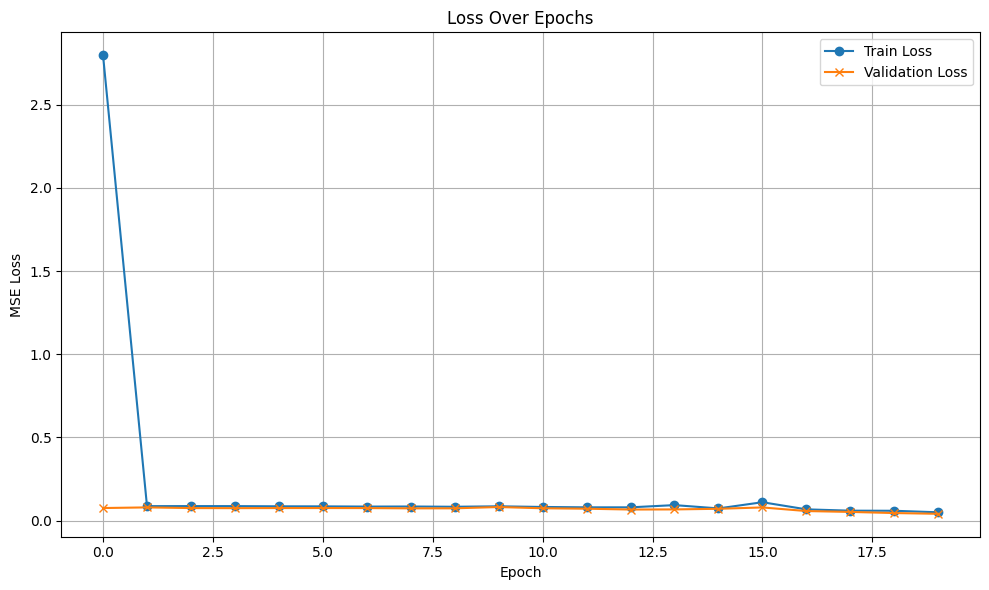

In [53]:
# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

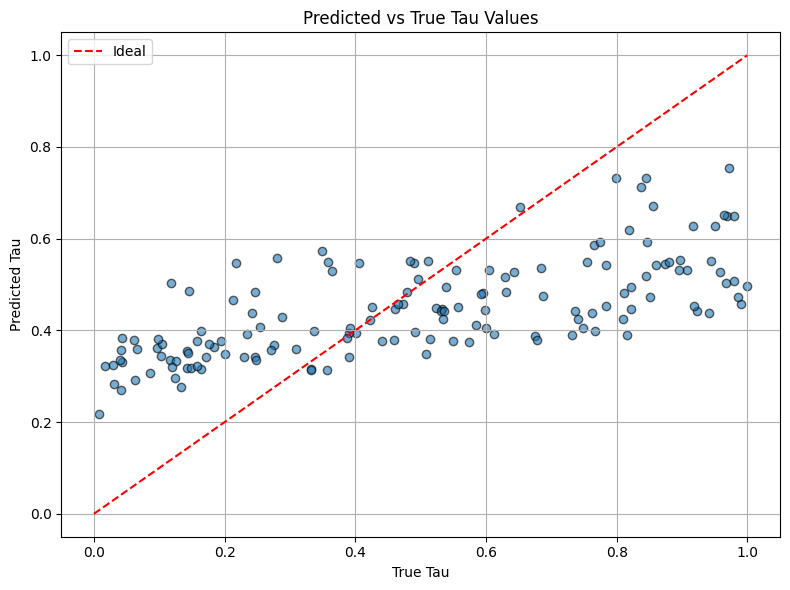

In [54]:
# Prediction vs Ground Truth
plt.figure(figsize=(8, 6))
plt.scatter(targets_all, predictions_all, alpha=0.6, edgecolors='k')
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.title("Predicted vs True Tau Values")
plt.xlabel("True Tau")
plt.ylabel("Predicted Tau")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

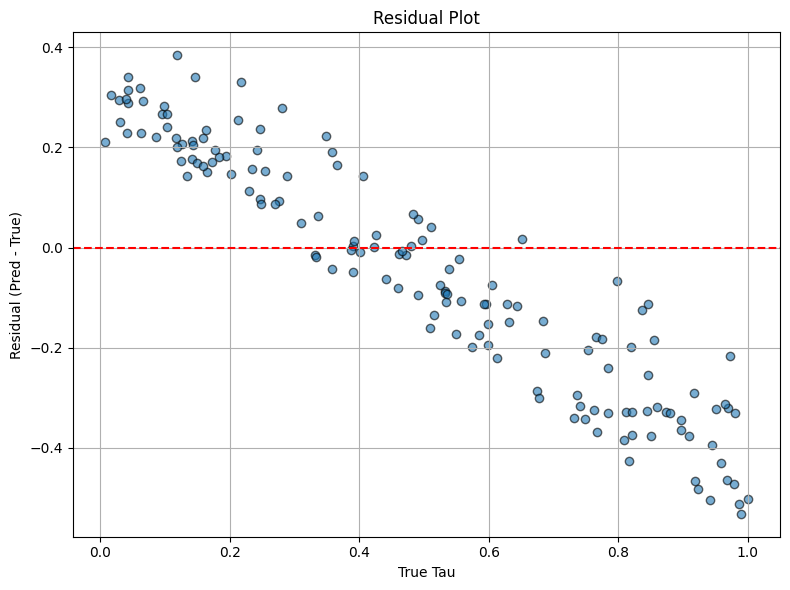

In [55]:
# Residuals
residuals = predictions_all - targets_all
plt.figure(figsize=(8, 6))
plt.scatter(targets_all, residuals, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("True Tau")
plt.ylabel("Residual (Pred - True)")
plt.grid(True)
plt.tight_layout()
plt.show()

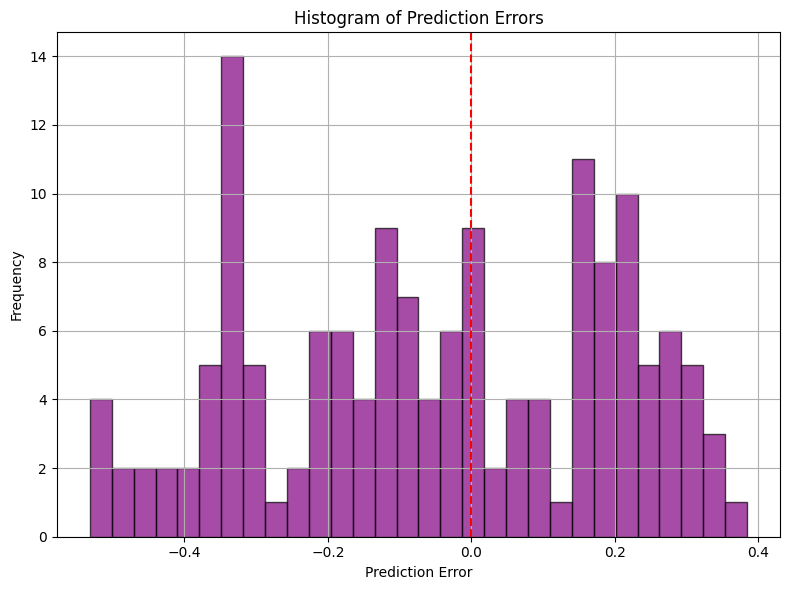

Test samples: 150


In [56]:
# Histogram
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.title("Histogram of Prediction Errors")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Test samples: {len(test_set)}")